In [41]:
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
plt.rcParams["figure.figsize"] = (15, 5)

**Import and prepare data**

Add extra columns

In [43]:
def prepare_data(coin):
    df = pd.read_csv(f'../../crypto_prices/coin_{coin}.csv', index_col=0).reset_index()
    df.Date = pd.to_datetime(df.Date)
    df['dayofweek'] = df.Date.dt.dayofweek
    df['dayofmonth'] = df.Date.dt.day
    df['year_month'] = df.Date.dt.strftime("%Y-%m")
    df['avg_daily_price']= (df.High + df.Low) / 2
    return df

**Calculate profit**

Given the provided dataframe for a specific coin, and the configuration for the frequency of the DCA plan, calculate the profit in percantage accumulated over the specified time window.

In [44]:
def calculate_profit_dca(df, frequency, purchase_year_month = '2018-01',\
                        purchase_day_of_week = 0, purchase_day_of_month = [0]):
    purchase_usd = 10
    if frequency == 'monthly':
        freq_cond = (df.dayofmonth.isin(purchase_day_of_month))
    if frequency == 'weekly':
        freq_cond = (df.dayofweek == purchase_day_of_week)

    purchase = df[(df.year_month >= purchase_year_month) & freq_cond]
    purchased_amount = (purchase_usd/purchase.High).sum()
    investment_amount = purchase_usd * len(purchase)
    investment_value = df[-1:].High * purchased_amount
    return (investment_value / investment_amount)

The considered coins

In [45]:
coins = ['Bitcoin', 'Ethereum', 'Polkadot']

Calculate profits for each day of the week, given a weekly DCA

In [46]:
day_of_week_profit = {'day': []}
for i in range(0,7):
    day_of_week_profit['day'].append(i)

for coin in coins:
    df = prepare_data(coin)
    day_of_week_profit[coin] = []
    print(f"Calculating profit for coin {coin}. Sample size {len(df)}...")
    for i in range(0,7):    
        day_of_week_profit[coin].append(calculate_profit_dca(df, 'weekly', purchase_day_of_week=i).iloc[0])

Calculating profit for coin Bitcoin. Sample size 2991...
Calculating profit for coin Ethereum. Sample size 2160...
Calculating profit for coin Polkadot. Sample size 320...


In [47]:
profit_df = pd.DataFrame(day_of_week_profit).set_index('day')

Let's plot the values

In [48]:
profit_df

,Bitcoin,Ethereum,Polkadot
day,,,
0,4.049776,8.685145,1.748500
1,4.055809,8.732725,1.744246
2,4.061459,8.746297,1.742078
3,4.059354,8.754766,1.723874
4,4.087846,8.822309,1.803979
5,4.080441,8.780460,1.770333
6,4.076108,8.746926,1.784881


<AxesSubplot:xlabel='day'>

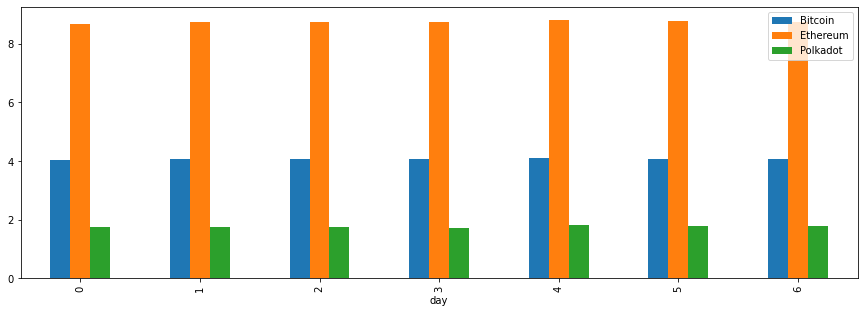

In [49]:
(profit_df).plot(kind='bar')

We standardize the values to cancel out the scale of the different coins and obtain a more visually intuitive reppresentation.

<AxesSubplot:xlabel='day of week', ylabel='z-score profit'>

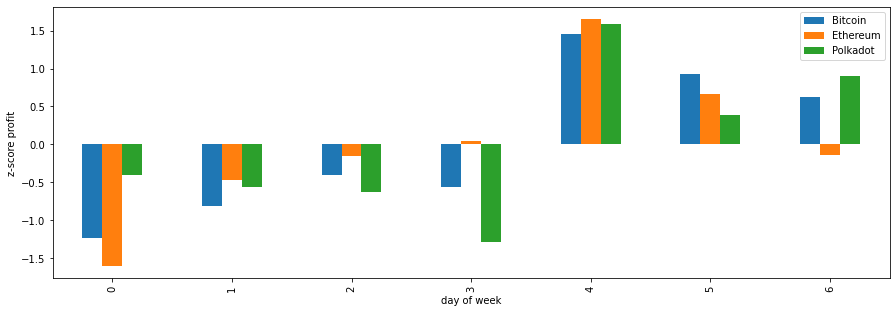

In [50]:
((profit_df - profit_df.mean())/profit_df.std()).plot(kind='bar', ylabel='z-score profit', xlabel='day of week')

The plot shows that Friday is the day where all coins provide the most profits.
Let's calcutate the best day for a portfolio comprised of these coins in different shares.
It is after all not correct to give all coins the same importance. Furthermore, some coins represent a larger part of the portfolio and we are therefore interested in giving these priority.
We use the rank for the days and maximise the sum.
We give each coin a weight and find the maximum.

In [51]:
profit_df.rank()\
         .transpose()\
         .apply(lambda x: (x.Bitcoin*40)+(x.Ethereum*40)+(x.Polkadot*20)).idxmax()

4

The formula confirmas that the day that maximises the profits is Friday